## Scalability Experiment (Section 5.3)

The experiment is designed to compare the execution time of different coarsening schemes over increasingly large graphs.

* For consistency, we use a regular graph of increasing size (vertices, edges) but always the same degree
* The reduction is fixed to 0.5. The execution time will only slightly increase for larger ratios (since the problem that has to be solved becomes easier at consecutive levels where the graph is smaller)
* If the execution time exceeds a budget (set to 100 sec), computation is skipped.

The code accompanies paper [Graph reduction with spectral and cut guarantees](http://www.jmlr.org/papers/volume20/18-680/18-680.pdf) by Andreas Loukas published at JMLR/2019 ([bibtex](http://www.jmlr.org/papers/v20/18-680.bib)).

This work was kindly supported by the Swiss National Science Foundation (grant number PZ00P2 179981).

15 March 2019

[Andreas Loukas](https://andreasloukas.blog)

[![DOI](https://zenodo.org/badge/175851068.svg)](https://zenodo.org/badge/latestdoi/175851068)

Released under the Apache license 2.0

In [1]:
!pip install networkx

DEPRECATION: Loading egg at /home/codespace/.local/lib/python3.12/site-packages/sortedcontainers-2.4.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/codespace/.local/lib/python3.12/site-packages/PyGSP-0.5.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_11067/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
import sys
import os

# 获取当前工作目录
current_dir = os.getcwd()

# 获取上级目录路径
parent_dir = os.path.dirname(current_dir)

# 将上级目录添加到 sys.path
sys.path.insert(0, parent_dir)

# 现在可以导入上级目录中的模块
from graph_coarsening.coarsening_utils import *
import graph_coarsening.graph_utils

# 示例使用
# coarsening_utils.some_function()
# graph_utils.some_other_function()


In [6]:
from graph_coarsening.coarsening_utils import *
import graph_coarsening.graph_lib as graph_lib
import graph_coarsening.graph_utils as graph_utils

import numpy as np
import scipy as sp
from scipy import io
from scipy.linalg import circulant
import time
import os 

import matplotlib
import matplotlib.pylab as plt

import pygsp as gsp
from pygsp import graphs, filters
gsp.plotting.BACKEND = 'matplotlib'

In [8]:
# Experiment parameters
N_all        = np.logspace(2, 6, 30, dtype=int)
methods      = ['heavy_edge', 'variation_edges', 'variation_neighborhoods', 'algebraic_JC', 'affinity_GS', 'kron'] 
K_all        = [10,80] #[10, 20, 40]
r            = 0.5
budget       = 100 # don't run anything that takes longer than this (in seconds)
n_iterations = 10
deg          = 10
algorithm    = 'greedy'  
n_methods    = len(methods)
# print(deg*N_all/2)

### The actual experiment code (this will take long)
If one needs to just see the results, skip running this part.

In [9]:
rerun_all = False
rewrite_results = False
if rerun_all:

    timings = np.zeros((len(N_all), len(K_all), n_methods, n_iterations)) * np.nan
    skip    = np.zeros(len(methods))

    for NIdx, N in enumerate(N_all):

        G = graph_lib.models(N, 'regular', k=deg) 

        for KIdx, K in enumerate(K_all):
            for methodIdx,method in enumerate(methods):

                if skip[methodIdx] == 1 :
                    timings[NIdx, KIdx, methodIdx] = np.nan
                    print('skipping: {}, {}, {}'.format(N, method, K))
                    continue

                timing = 0
                for iteration in range(n_iterations):
                    if method == 'kron':
                        start = time.time()
                        _, tmp  = kron_coarsening(G, r=r, m=None)
                        end = time.time()
                        if tmp == None: 
                            print('kron failed... skipping')
                            continue
                    else:
                        start = time.time()
                        _, _, Call, _ = coarsen(G, K=K, r=r, max_levels=4, method=method, algorithm=algorithm)
                        end = time.time()

                        if len(Call) >= 4: print('warning: too many levels for {}, r:{}, K:{}'.format(method, r, K) )

                    timings[NIdx, KIdx, methodIdx, iteration] = end-start

                timing = np.mean(timings[NIdx, KIdx, methodIdx, :])            
                skip[methodIdx] = 1 if (timing > budget) else 0

        print('N = {}, done!'.format(N))

        if sum(skip) == len(methods): break

    if rewrite_results:
        filepath = os.path.join('..', 'results', 'experiment_scalability.npz')
        print('.. saving to "' + filepath + '"')
        np.savez(filepath, methods=methods, K_all=K_all, N_all=N_all, timings=timings, deg=deg, budget=budget)

print('done!')

done!


### Load results

In [10]:
filepath = os.path.join('..', 'results', 'experiment_scalability.npz')
data = np.load(filepath)

methods, K_all, N_all, timings, deg, budget = data['methods'], data['K_all'], data['N_all'], data['timings'], data['deg'], data['budget'] 

### Visualize them

The produced figures are used in the paper

The figures are drawn in the following in order:
* experiment_scalability_K=10
* experiment_scalability_K=40


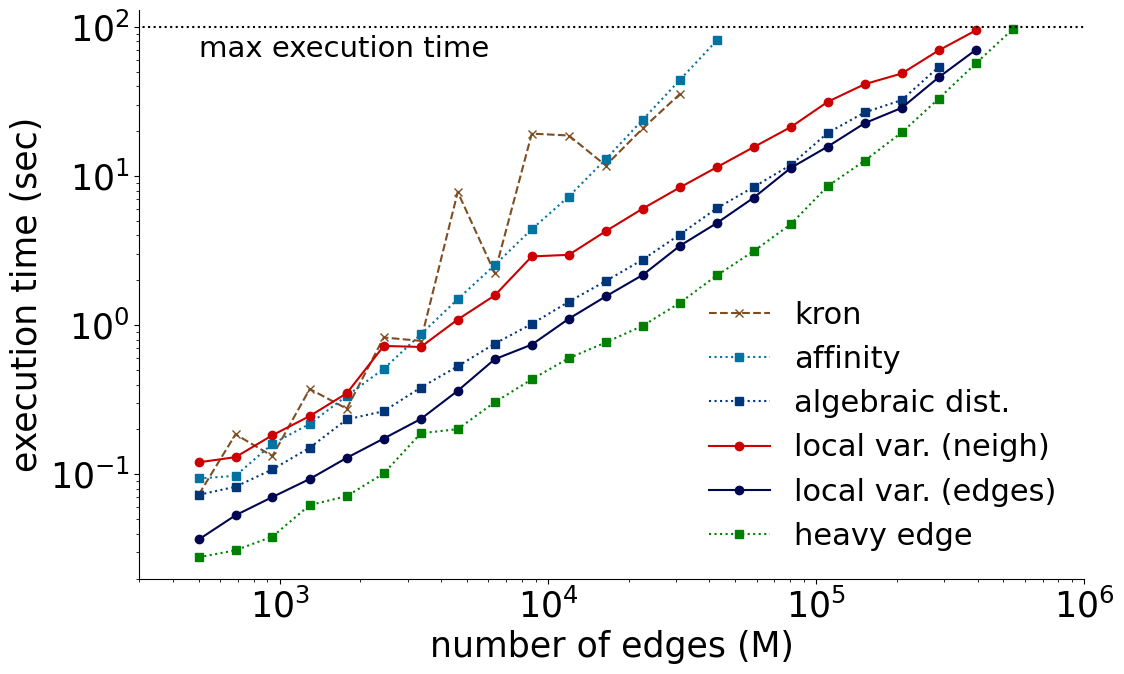

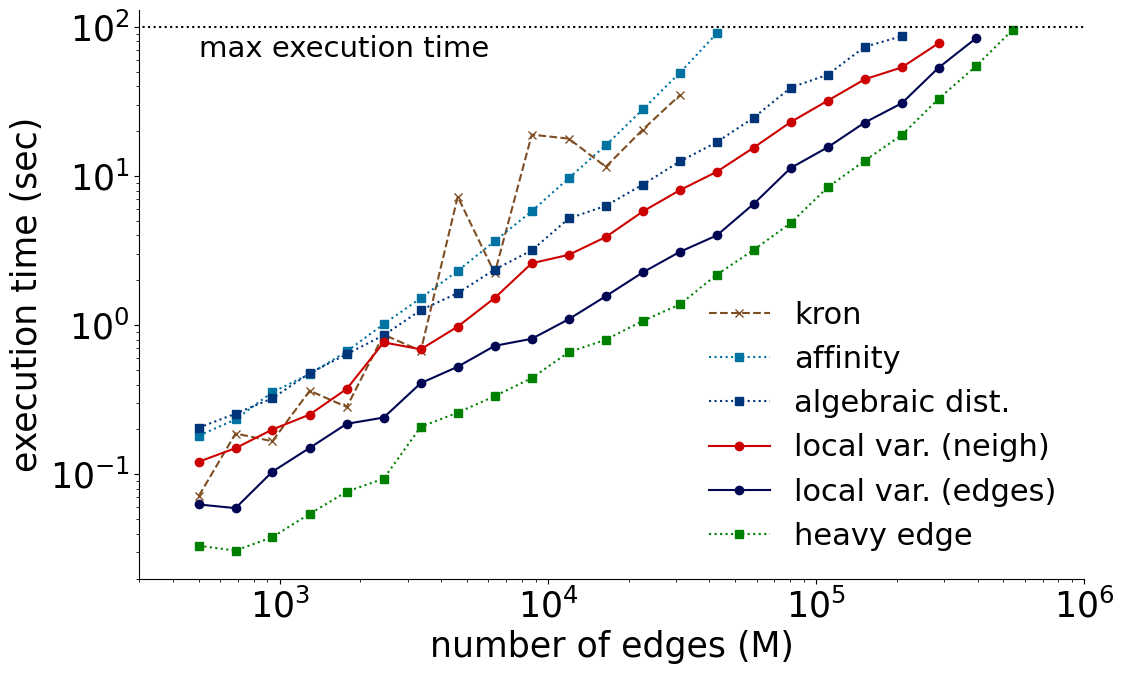

In [11]:
matplotlib.rcParams.update({'font.size': 25})

from matplotlib import cm
colors = [ cm.ocean(x) for x in np.linspace(0, 0.95, len(methods)+1)]
colors[1] = [0.8,0,0] 
colors[-2] = (np.array([127, 77, 34])/255).tolist()  

size = 2.7*2.7; 

print('The figures are drawn in the following in order:')
for KIdx, K in enumerate(K_all):
        
    fig, axes = plt.subplots(1, 1, figsize=(1.618*size, size)); 
    for methodIdx,method in reversed(list(enumerate(methods))):
 
        linewidth = 1.5; marker = 's'
        method = method.replace('_', ' ')                
        if method == 'heavy edge':
            method = 'heavy edge'
            cIdx, line, marker = 0, ':', 's'
        elif 'variation edges' in method:
            method = 'local var. (edges)'
            cIdx, line, marker, linewidth = 2, '-', 'o', 1.5
        elif (method == 'variation neighborhoods') or (method == 'variation neighborhood'):
            method = 'local var. (neigh)'
            cIdx, line, marker, linewidth = 1, '-', 'o', 1.5 
        elif 'algebraic' in method:
            method = 'algebraic dist.'
            cIdx, line = 3, ':'
        elif 'affinity' in method:
            method = 'affinity'
            cIdx, line = 4, ':'
        elif method == 'kron':
            method = 'kron'
            cIdx, line, marker = 5, '--', 'x'
        else:
            continue
            
        style = line + marker 
        color = colors[cIdx]
        
        tmp = np.mean(timings[:,KIdx,methodIdx,:], 1)
        tmp[tmp>budget] = np.nan
        axes.plot(N_all*deg/2, tmp, style, label='{}'.format(method), color=color, linewidth=linewidth, markersize=6)

    axes.plot(np.array([10, N_all[-1]])*deg/2, [budget, budget], 'k:')
    
    axes.set_xscale('log')
    axes.set_yscale('log')
    axes.set_xlabel('number of edges (M)')
    axes.set_ylabel('execution time (sec)')
    axes.set_ylim([0.02, budget+30])
    axes.set_xlim([300, N_all[-1]])
    
    legend0 = axes.legend(fontsize=22, loc='lower right', edgecolor=[1,1,1])

    axes.text(500, 63, 'max execution time', fontsize=21)
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
        
    fig.tight_layout()
    
    print('* experiment_scalability_K='+ str(K))
#     fig.savefig(os.path.join('..', 'results', 'experiment_scalability_K='+ str(K) +'.pdf'))